In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import pygrib
import cfgrib
import glob

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

In [2]:

class Data():
    def get_eps_data(experiments, inidate='2022-02-16'):
        """
        Function to load comlete data of simulations on surface level since
        xr has a bug that prevents using
        this as a simpler solution

        Input:
        ------
        experiments: list of strings, list of experiments to import,
                e.g. ['pi', 'curr', 'incr']

        Output:
        -------
        eps: list of xarrays, data and metadata of operational forecasts,
        each list entry is one experiment
        """

        directory = {'pi': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/',
                    'curr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/',
                    'incr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/'}

        eps = {}
        for experiment in experiments:
            exp_eps = []
            for c, cont in enumerate(['cf', 'pf']):
                for files in glob.glob(directory[experiment]
                                        + cont + '/*'
                                        + inidate + '*.nc'):
                    print(files)
                    data = xr.open_dataset(files)
                    exp_eps.append(Data.preproc_ds(data.get(['fg10', 'msl',
                                                                'u10', 'v10',
                                                                'u100', 'v100'])))

            eps[experiment] = xr.concat(exp_eps, dim='number').squeeze()

        return eps
    

    def preproc_ds(ds):
        """
        Main pre-processing function
        Writtten by Nick Leach.

        Input:
        ------

        Output:
        -------
        """

        # accumulated variables & scaling factors
        accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                            'ttr': 1,
                            'tsr': 1,
                            'str': 1,
                            'ssr': 1,
                            'e': 1}
        accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                    'ttr': 'W m$^{-2}$',
                                    'tsr': 'W m$^{-2}$',
                                    'str': 'W m$^{-2}$',
                                    'ssr': 'W m$^{-2}$',
                                    'e': 'm s$^{-1}$'}
        ds = ds.copy().squeeze()
        # set up aux data
        inidate = pd.to_datetime(ds.time[0].values)
        # expand dimensions to include extra info
        if not 'hDate' in ds:
            ds = ds.expand_dims({'inidate': [inidate]}).copy()

        if not 'number' in ds:
            ds = ds.expand_dims({'number': [0]}).copy()

        # put time dimension at front
        ds = ds.transpose('time', ...)
        ds = ds.copy(deep=True)

        # convert accumulated variables into instantaneous
        for var, sf in accumulated_vars.items():
            if var in ds.keys():
                ds[var].loc[dict(time=ds.time[1:])] = Data.accum2rate(ds[var]) * sf
                # set first value to equal zero,
                # should be zero but isn't always
                ds[var].loc[dict(time=ds.time[0])] = 0
                ds[var].attrs['units'] = accumulated_var_newunits[var]
        return ds
        

Step 1: import the data (select the 16th with the same directory)
Step 2: select windstress data ()
Step 3: filter data (51 ensemble with 95% windgust and choose top 5)
Step 4: plot

In [3]:
da_pi = Data.get_eps_data(['pi'])
da_curr = Data.get_eps_data(['curr'])
da_incr = Data.get_eps_data(['incr'])

wind_gusts_pi = da_pi['pi'].sel(time='2022-02-16 12').fg10
wind_gusts_curr = da_curr['curr'].sel(time='2022-02-16 12').fg10
wind_gusts_incr = da_incr['incr'].sel(time='2022-02-16 12').fg10



/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2ns_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2ns_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2nt_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2nt_2022-02-16.nc


In [35]:
wind_gusts_pi

<xarray.DataArray 'fg10' (number: 51, latitude: 163, longitude: 289)>
array([[[ 4.8422375,  4.0874157,  3.8789997, ..., 13.963169 ,
         14.317613 , 14.664515 ],
        [ 3.9379597,  3.835123 ,  3.955099 , ..., 15.689455 ,
         15.863591 , 16.044584 ],
        [ 2.772478 ,  2.5647469,  2.9898052, ..., 16.832314 ,
         16.889902 , 16.943377 ],
        ...,
        [ 6.0406284,  6.5068216,  6.3422832, ...,  9.85587  ,
          9.253933 ,  9.808565 ],
        [ 6.4410057,  6.4115257,  6.3237724, ..., 10.610692 ,
         10.265846 , 10.153411 ],
        [ 6.637081 ,  6.2257347,  6.3957577, ..., 10.736838 ,
         10.794427 , 10.34126  ]],

       [[ 5.273985 ,  4.778372 ,  4.513052 , ..., 13.2388115,
         13.519892 , 13.81761  ],
        [ 4.041958 ,  4.1522884,  4.450882 , ..., 15.52686  ,
         15.784299 , 15.983945 ],
        [ 2.5866432,  2.5122128,  3.1803265, ..., 16.616158 ,
         16.739624 , 16.826311 ],
...
        [ 6.428953 ,  7.329113 ,  7.240673 , ...,  9.5331   ,
          8.935913 ,  9.5602455],
        [ 7.103197 ,  7.1399746,  6.773081 , ..., 10.149551 ,
          9.667072 ,  9.767773 ],
        [ 7.0602913,  6.8335   ,  6.3825455, ..., 10.525202 ,
         10.228359 ,  9.853584 ]],

       [[ 5.328274 ,  4.360691 ,  4.0113106, ..., 14.579417 ,
         14.927922 , 15.257163 ],
        [ 4.2538624,  4.049839 ,  4.0848637, ..., 16.27378  ,
         16.494444 , 16.659065 ],
        [ 2.8589668,  2.5218449,  2.9579144, ..., 17.359577 ,
         17.500555 , 17.581114 ],
        ...,
        [ 5.825638 ,  6.982359 ,  7.6688614, ...,  9.520842 ,
          8.878996 ,  9.550613 ],
        [ 7.3037186,  7.53664  ,  7.6408405, ...,  9.843077 ,
          9.456043 ,  9.749384 ],
        [ 7.385153 ,  7.2003937,  7.0760517, ...,  9.79229  ,
          9.4376545,  9.7730255]]], dtype=float32)
Coordinates:
  * number     (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    inidate    datetime64[ns] 2022-02-16
  * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0
    time       datetime64[ns] 2022-02-16T12:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre wind gust since previous post-processing

In [22]:
lat = da_pi['pi'].sel(time='2022-02-16 12').latitude.values
lon = da_pi['pi'].sel(time='2022-02-16 12').longitude.values

In [51]:
'''
avg_wg_pi = []
pi_max = []
for num in wind_gusts_pi.number:
    avg_wg_pi.append(wind_gusts_pi.sel(number=num).quantile(0.95))
    pi_max.append(max(wind_gusts_pi.sel(number=num).quantile(0.95)))

avg_wg_pi
pi_max
'''

avg_wg_pi = wind_gusts_pi.quantile(0.95,dim=['latitude','longitude'])
#avg_wg_curr = wind_gusts_curr.quantile(0.95,dim='number')
#avg_wg_incr = wind_gusts_incr.quantile(0.95,dim='number')
avg_wg_pi

<xarray.DataArray 'fg10' (number: 51)>
array([21.78129578, 22.45142746, 21.6221962 , 22.57988358, 21.74023228,
       21.0916441 , 21.46641903, 23.03022575, 21.63156509, 22.40475521,
       21.90134983, 21.5404974 , 23.43485813, 21.60477047, 21.94915886,
       21.51405373, 22.14670372, 23.27873211, 23.82364388, 21.30302334,
       22.55974312, 21.56352615, 22.11491833, 21.5985527 , 22.48032379,
       23.41524506, 21.8198267 , 22.20624733, 21.3892746 , 21.76308594,
       21.45056915, 21.59741459, 21.97507858, 22.53435001, 23.31410885,
       22.09941864, 22.28768158, 22.10423508, 21.40363426, 21.64146042,
       21.58287926, 22.03812408, 21.87744427, 21.96255741, 22.52252922,
       21.73699169, 21.33218231, 24.17547569, 22.62813034, 21.47613869,
       21.45906315])
Coordinates:
  * number    (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    quantile  float64 0.95

I have no idea why the output is flat--I mean, did I select a specific number of experiment? No!


/tmp/user/27783/ipykernel_1037925/2024895919.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable=None)


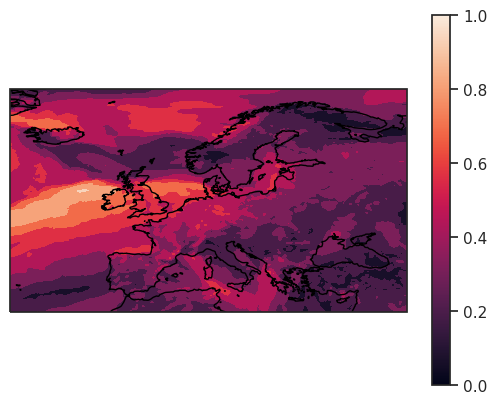

In [46]:
fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
lon = lon[]
ax.contourf(lon, lat, avg_wg_pi)
ax.coastlines()
plt.xlabel('longtitude')
plt.ylabel('latittude')
fig.colorbar(mappable=None)

/tmp/user/27783/ipykernel_1037925/3481477677.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable=None)
/tmp/user/27783/ipykernel_1037925/3481477677.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable=None)


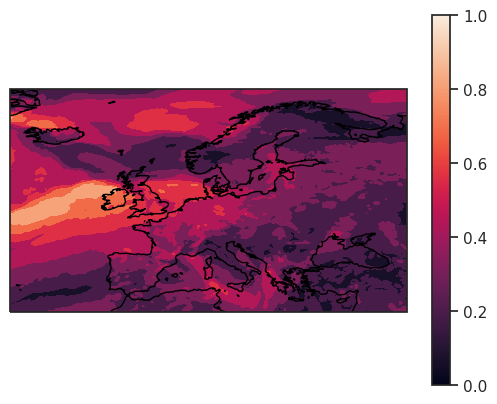

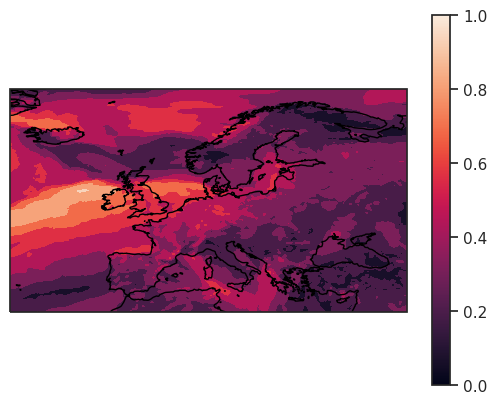

In [48]:
fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.contourf(lon, lat, avg_wg_curr)
ax.coastlines()
plt.xlabel('longtitude')
plt.ylabel('latittude')
fig.colorbar(mappable=None)


fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.contourf(lon, lat, avg_wg_incr)
ax.coastlines()
plt.xlabel('longtitude')
plt.ylabel('latittude')
fig.colorbar(mappable=None)
